In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from typing import Optional
import random
import numpy as np
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from syd import make_viewer, Viewer
from tqdm import tqdm

from vrAnalysis.helpers import Timer, format_spines, beeswarm, errorPlot, save_figure
from dimilibi import PCA, SVCA


from dimensionality_manuscript.simulations import (
    CovarianceGenerator,
    PowerlawDataGenerator, 
    RotatedEigenbasisGenerator,
    geometric_mean_spd, 
    root_sandwich,
    plot_ellipse, 
    get_orthogonal_direction, 
    generate_orthonormal,
    sqrtm_spd,
)

plt.rcParams["font.size"] = 14

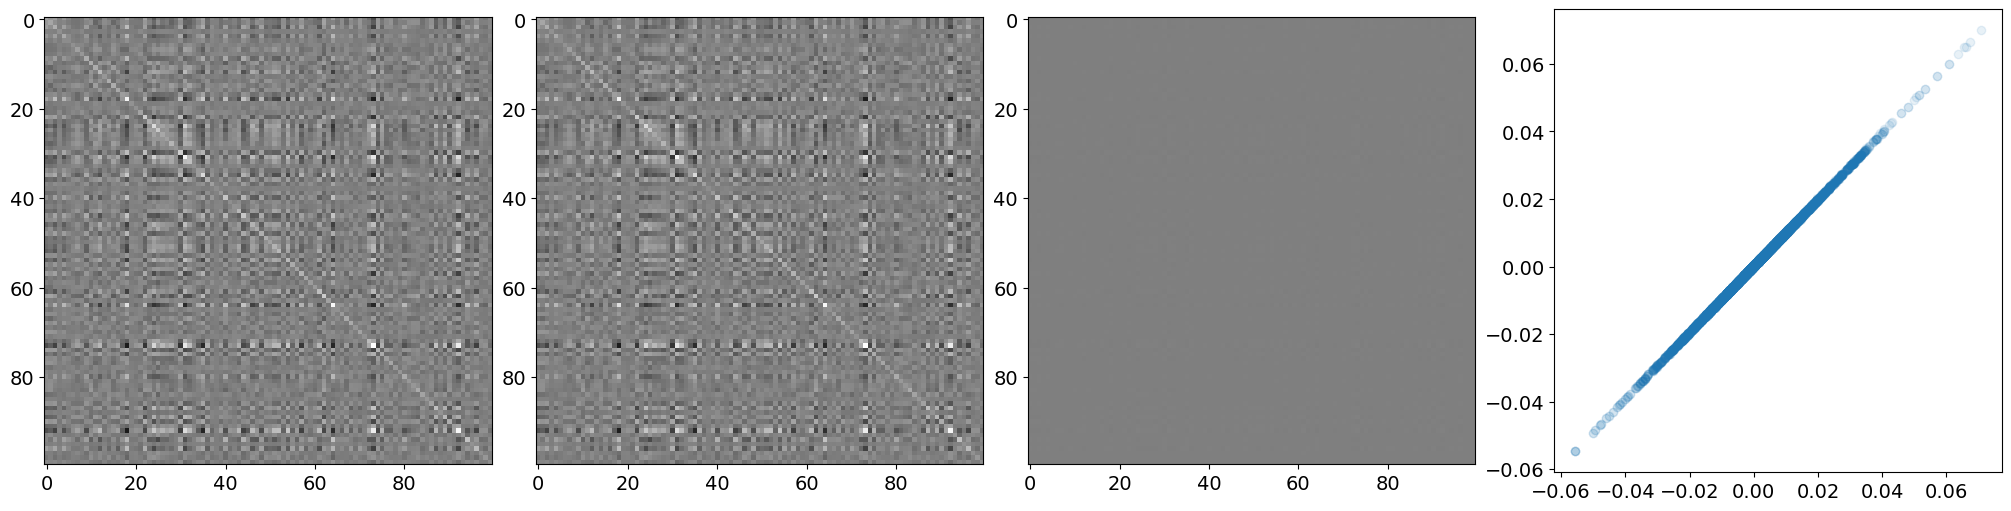

In [142]:
def gaussian_resample(data: np.ndarray, cholesky: bool = False):
    mu = np.mean(data, axis=0)
    cov = np.cov(data)
    evals, evecs = np.linalg.eigh(cov)
    if cholesky:
        dev = np.linalg.cholesky(cov) @ np.random.randn(*data.shape)
    else:
        dev = evecs @ np.diag(np.sqrt(evals)) @ np.random.randn(*data.shape)
    return dev + mu

N = 100
S = 50000

gen1 = CovarianceGenerator.powerlaw(num_neurons=N, alpha=1.5)
data1 = gen1.generate(S)

resample1 = gaussian_resample(data1, cholesky=False)

cov1 = np.cov(data1)
rscov1 = np.cov(resample1)

max_val = np.max(np.abs(np.stack([cov1, rscov1, cov1 - rscov1])))

plt.close('all')
fig, ax = plt.subplots(1, 4, figsize=(20, 5), layout="constrained") 
ax[0].imshow(cov1, cmap="gray", vmin=-max_val, vmax=max_val)
ax[1].imshow(rscov1, cmap="gray", vmin=-max_val, vmax=max_val)
ax[2].imshow(cov1 - rscov1, cmap="gray", vmin=-max_val, vmax=max_val)
ax[3].scatter(cov1.flatten(), rscov1.flatten(), alpha=0.1)
plt.show()


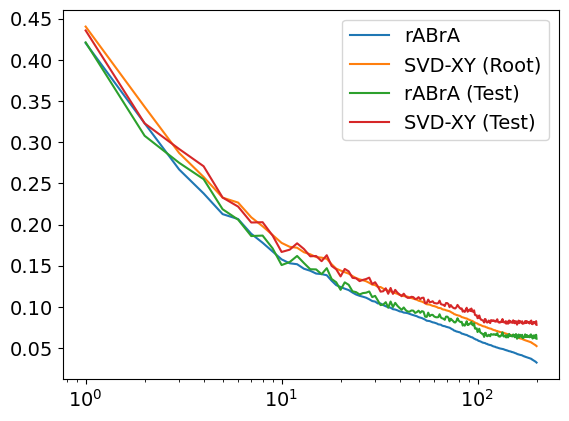

In [124]:
N = 200
S = 2000
rank = 100
noise_variance = 0.05

norm_denom = (S - 1) * (S - 1)

gen1 = CovarianceGenerator.powerlaw(num_neurons=N, rank=rank, alpha=0.9)
gen2 = gen1.variant("rotate_block", k=80, where="top", strength=0.98)
data1 = gen1.generate(S, noise_variance=noise_variance)
data2 = gen2.generate(S, noise_variance=noise_variance)
test1 = gen1.generate(S, noise_variance=noise_variance)
test2 = gen2.generate(S, noise_variance=noise_variance)

A = np.cov(data1)
B = np.cov(data2)
rA = sqrtm_spd(A)
rB = sqrtm_spd(B)

# Measure on training data
evals_rABAr, evecs_rABAr = np.linalg.eigh(rA @ B @ rA)
evals_rABAr = np.sqrt(np.maximum(0, evals_rABAr))[::-1]
evecs_rABAr = evecs_rABAr[:, ::-1]
Uroot, svals_xyroot, Vtroot = np.linalg.svd(rA @ rB)

# Measure on test data
Atest = np.cov(test1)
Btest = np.cov(test2)
rAtest = sqrtm_spd(Atest)
rBtest = sqrtm_spd(Btest)
evals_rABAr_test = np.sqrt(np.diag(evecs_rABAr.T @ rAtest @ Btest @ rAtest @ evecs_rABAr))
svals_xy_test = np.diag(Uroot.T @ rAtest @ rBtest @ Vtroot.T)


xvals = lambda x: range(1, len(x)+1)
norm = lambda x: x / np.sum(x)

plt.close('all')
plt.plot(xvals(evals_rABAr), evals_rABAr + 0.00, label="rABrA")
plt.plot(xvals(svals_xyroot), svals_xyroot + 0.02, label="SVD-XY (Root)")
plt.plot(xvals(evals_rABAr_test), evals_rABAr_test + 0.01, label="rABrA (Test)")
plt.plot(xvals(svals_xy_test), svals_xy_test + 0.03, label="SVD-XY (Test)")
plt.xscale('log')
plt.legend()
plt.show()

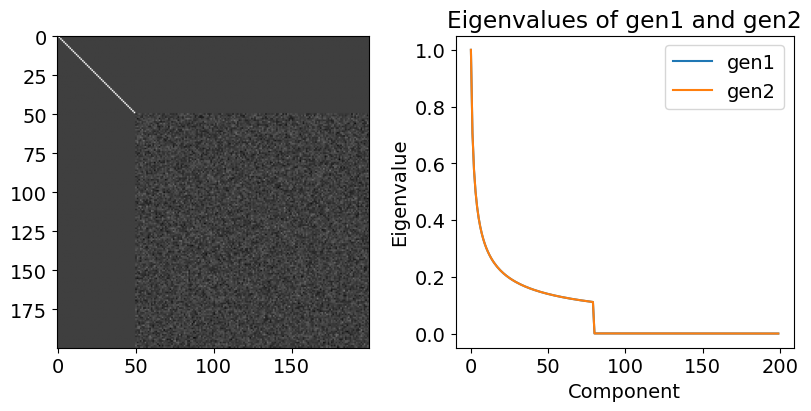

In [78]:
N = 200
S = 2000
noise_variance = 0.0

gen1 = CovarianceGenerator.powerlaw(num_neurons=N, alpha=0.5)
gen2 = gen1.variant("rotate_block", k=150, where="tail", strength=0.9)

gen1 = gen1.variant("band_scale_spectrum", k_tail=120, scale_tail=0.01)
gen2 = gen2.variant("band_scale_spectrum", k_tail=120, scale_tail=0.01)

plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout='constrained')
ax[0].imshow(gen1.eigenvectors.T @ gen2.eigenvectors, cmap="gray")
ax[1].plot(gen1.eigenvalues, label="gen1")
ax[1].plot(gen2.eigenvalues, label="gen2")
ax[1].legend()
ax[1].set_xlabel("Component")
ax[1].set_ylabel("Eigenvalue")
ax[1].set_title("Eigenvalues of gen1 and gen2")
plt.show()

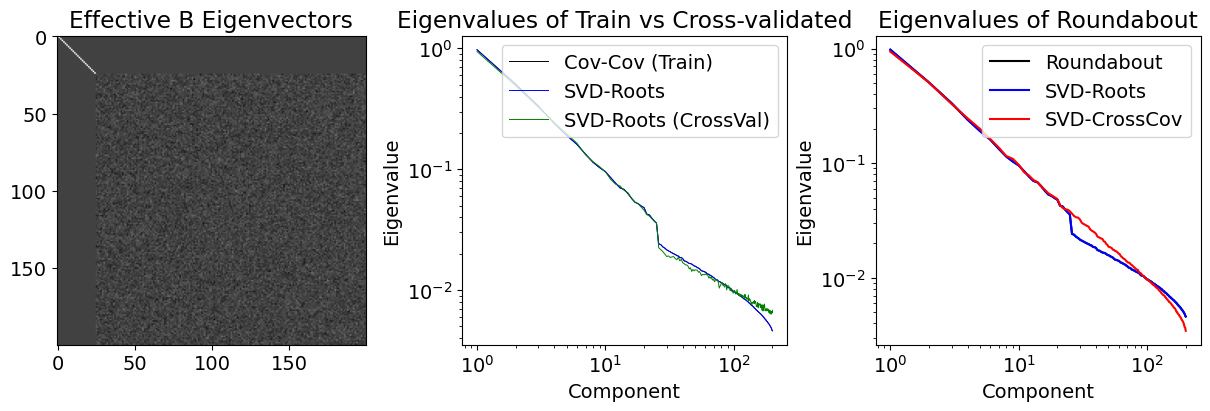

In [90]:
N = 200
S = 2000
rank = 100
noise_variance = 0.001

# Generate rotated eigenvectors
gen1 = CovarianceGenerator.powerlaw(num_neurons=N, alpha=1.03)
gen2 = gen1.variant("rotate_block", k=175, where="tail", strength=0.9)

# Flatten tail eigenvalues to get effective rank of 50
# gen1 = gen1.variant("band_scale_spectrum", k_tail=150, scale_tail=0.001)
# gen2 = gen2.variant("band_scale_spectrum", k_tail=150, scale_tail=0.001)

data1 = gen1.generate(S, noise_variance=noise_variance)
data2 = gen2.generate(S, noise_variance=noise_variance)
ndata1 = data1 - np.mean(data1, axis=1, keepdims=True)
ndata2 = data2 - np.mean(data2, axis=1, keepdims=True)

test1 = gen1.generate(S, noise_variance=noise_variance)
test2 = gen2.generate(S, noise_variance=noise_variance)
ntest1 = test1 - np.mean(test1, axis=1, keepdims=True)
ntest2 = test2 - np.mean(test2, axis=1, keepdims=True)

C1 = np.cov(data1)
C2 = np.cov(data2)
C1test = np.cov(test1)
C2test = np.cov(test2)

rC1 = sqrtm_spd(C1)
rC2 = sqrtm_spd(C2)
rCross12 = rC1 @ rC2
U, s, Vt = np.linalg.svd(rCross12)

# Crossvalidate SVD-Roots version
rC1test = sqrtm_spd(C1test)
rC2test = sqrtm_spd(C2test)
rCross12test = rC1test @ rC2test
s_cv = np.diag(U.T @ rCross12test @ Vt.T)
s_check = np.diag(U.T @ rCross12 @ Vt.T)

# Root Sandwich version
cc121 = root_sandwich(C1, C2)
cc121test = root_sandwich(C1test, C2test)
evals_cc121, evecs_cc121 = np.linalg.eigh(cc121)
val_evals = np.sum(evecs_cc121 * (cc121 @ evecs_cc121), axis=0)
evals_shared = np.sqrt(np.maximum(0, evals_cc121))
evals_test = np.sqrt(np.maximum(0, np.sum(evecs_cc121 * (cc121test @ evecs_cc121), axis=0)))

# SVD Cross-Covariance Version
C12 = np.cov(data1, data2)[N:][:, N:]
Uc, Sc, Vtc = np.linalg.svd(C12)
scc_check = np.diag(Uc.T @ C12 @ Vtc.T)


plt.close('all')
fig, ax = plt.subplots(1, 3, figsize=(12, 4), layout='constrained')
ax[0].imshow(gen1.eigenvectors.T @ gen2.eigenvectors, cmap="gray")
ax[0].set_title("Effective B Eigenvectors")
ax[1].plot(range(1, N+1), np.flipud(evals_shared), color="k", label="Cov-Cov (Train)", linewidth=0.7)
ax[1].plot(range(1, N+1), s, color="b", label="SVD-Roots", linewidth=0.7)
# ax[1].plot(range(1, N+1), scc_check, color="r", label="SVD-CrossCov", linewidth=0.7)
ax[1].plot(range(1, N+1), s_cv, color="g", label="SVD-Roots (CrossVal)", linewidth=0.7)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_xlabel("Component")
ax[1].set_ylabel("Eigenvalue")
ax[1].set_title("Eigenvalues of Train vs Cross-validated")
ax[2].plot(range(1, N+1), s, color="k", label="Roundabout")
ax[2].plot(range(1, N+1), s_check, color="b", label="SVD-Roots")
ax[2].plot(range(1, N+1), scc_check, color="r", label="SVD-CrossCov")
ax[2].set_xlabel("Component")
ax[2].set_ylabel("Eigenvalue")
ax[2].set_title("Eigenvalues of Roundabout")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].legend()
plt.show()